In [1]:
%matplotlib inline
import collections
import math
import os
os.makedirs("/kaggle/working/data")
os.chdir("/kaggle/input/d2lcode")
import shutil
import pandas as pd
import torch
import torchvision
from torch.utils import data
from IPython import display
from torchvision import transforms
from torch import nn
import d2l
d2l.use_svg_display()

In [2]:
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="/kaggle/working/data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="/kaggle/working/data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=4),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=4))


In [3]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

100%|██████████| 26421880/26421880 [00:01<00:00, 18443990.10it/s]


Extracting /kaggle/working/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 300482.50it/s]


Extracting /kaggle/working/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5553438.39it/s]


Extracting /kaggle/working/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9721871.68it/s]

Extracting /kaggle/working/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/data/FashionMNIST/raw



# resnet18  对CNN进行改进

In [14]:
resnet=d2l.resnet18(10,1)
loss=nn.CrossEntropyLoss(reduction="none")

In [15]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    valid_accMax=0
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                              weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('test acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels,
                                          loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            if(valid_acc>valid_accMax):
                valid_accMax=valid_acc
                name='/kaggle/working/params_'+str(i)
                torch.save(net.state_dict(),name)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', test acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

train loss 0.033, train acc 0.989, test acc 0.932
2744.1 examples/sec on [device(type='cuda', index=0)]


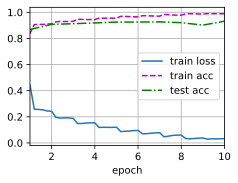

In [16]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, resnet
train(net, train_iter, test_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

[[-0.00607329  0.00239664 -0.00238228]
 [-0.00532479  0.00886988  0.01037151]
 [ 0.00629544  0.0053588   0.00106966]]


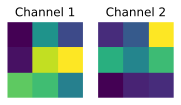

In [23]:
import matplotlib.pyplot as plt
def visualize_conv_weights(model, num_channels):#num_channels是输出通道数(也可以理解为我们有多少个三维卷积)，
    #layer_index是想要画的那一层的索引
    # 获取第0层（卷积层）的权重
    conv_weights = model.weight.cpu().detach().numpy()
    print(conv_weights[0][0])

    # 可视化每个通道的权重
    fig, axs = plt.subplots(1, num_channels, figsize=(3, 3))  #figsize一般是我们想要画的图的大小
    for i in range(num_channels):
        axs[i].imshow(conv_weights[i][0], cmap='viridis')
        axs[i].axis('off')
        axs[i].set_title(f'Channel {i+1}')

    plt.show()
visualize_conv_weights(resnet[6][1].conv1, 2)

# 用CNN，对应着第四讲中利用卷积神经网络的自动特征提取，p13  ，可以对卷积核进行可视化，第8组P22


In [9]:
cnn = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(64*4*4, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )


train loss 0.264, train acc 0.902, test acc 0.903
27972.7 examples/sec on [device(type='cuda', index=0)]


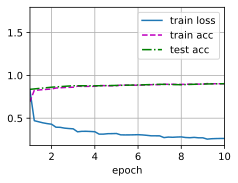

In [10]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, cnn
train(net, train_iter, test_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

[[-0.46926    -0.6447704  -0.09785095  0.23625962 -0.27212876]
 [ 0.00436897  0.13566186  0.07974502  0.29116833 -0.11102405]
 [-0.0673685   0.00375255 -0.28212732 -0.25084904  0.31814128]
 [-0.08822634 -0.0337977  -0.12118838  0.12707499  0.34922656]
 [-0.0712072   0.23112282  0.29167667  0.0319666   0.13159847]]


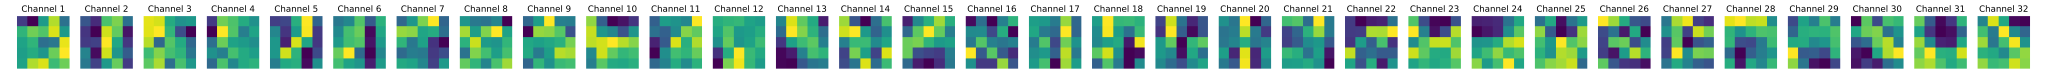

In [17]:
import matplotlib.pyplot as plt
def visualize_conv_weights(model, layer_index, num_channels):#num_channels是输出通道数(也可以理解为我们有多少个三维卷积)，
    #layer_index是想要画的那一层的索引
    # 获取第0层（卷积层）的权重
    conv_weights = model[layer_index].weight.cpu().detach().numpy()
    print(conv_weights[0][0])

    # 可视化每个通道的权重
    fig, axs = plt.subplots(1, num_channels, figsize=(50, 50))  #figsize一般是我们想要画的图的大小
    for i in range(num_channels):
        axs[i].imshow(conv_weights[i][0], cmap='viridis')
        axs[i].axis('off')
        axs[i].set_title(f'Channel {i+1}')

    plt.show()
visualize_conv_weights(net, 0, 32)

# 利用CLIP linear probing 做分类 

In [1]:
!pip install ftfy regex tqdm

  Obtaining dependency information for ftfy from https://files.pythonhosted.org/packages/91/f8/dfa32d06cfcbdb76bc46e0f5d69c537de33f4cedb1a15cd4746ab45a6a26/ftfy-6.1.3-py3-none-any.whl.metadata
  Obtaining dependency information for wcwidth<0.3.0,>=0.2.12 from https://files.pythonhosted.org/packages/31/b1/a59de0ad3aabb17523a39804f4c6df3ae87ead053a4e25362ae03d73d03a/wcwidth-0.2.12-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: wcwidth
    Found existing installation: wcwidth 0.2.6
    Uninstalling wcwidth-0.2.6:
      Successfully uninstalled wcwidth-0.2.6


In [2]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-1segdvj6
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-1segdvj6
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=aafbee8d58f3c2a04c32b0c3005863ee1ad779162f8262e15302ea8ca2eb4395
  Stored in directory: /tmp/pip-ephem-wheel-cache-7ub8ak8b/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [3]:
import torch
import clip
from PIL import Image

In [4]:
%matplotlib inline
import collections
import math
import os
os.makedirs("/kaggle/working/data")
os.chdir("/kaggle/input/d2lcode")
import shutil
import pandas as pd
import torch
import torchvision
from torch.utils import data
from IPython import display
from torchvision import transforms
from torch import nn
import d2l
d2l.use_svg_display()
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="/kaggle/working/data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="/kaggle/working/data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=4),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=4))
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

100%|██████████| 26421880/26421880 [00:01<00:00, 14388100.82it/s]


Extracting /kaggle/working/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 212609.91it/s]


Extracting /kaggle/working/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3871602.60it/s]


Extracting /kaggle/working/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 11010850.07it/s]

Extracting /kaggle/working/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/data/FashionMNIST/raw



# 先测试以下只用CLIP0样本进行分类的准度，效果不好

In [6]:
import torch
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
def test(num):
    for i,(features, labels) in enumerate(test_iter):
        for j in range(features.shape[0]):
            transform = transforms.ToPILImage()
            image = preprocess(transform(features[j])).unsqueeze(0).to(device)
            text = clip.tokenize(["a T-shirt", "a Trouser", "a Pullover","a Dress","a Coat","a Sandal","a Shirt"
                                 "a Sneaker","a Bag","a Ankle boot"]).to(device)

            with torch.no_grad():
                image_features = model.encode_image(image)
                text_features = model.encode_text(text)
                logits_per_image, logits_per_text = model(image, text)
                probs = logits_per_image.softmax(dim=-1).cpu()
                max_index_tensor = torch.argmax(probs)
                if(max_index_tensor==labels[j]): num+=1
        print("利用CLIP进行0样本学习分类的精度为{}".format(num/10000) )
num=0
test(num)








            
            
        
    

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 111MiB/s]


利用CLIP进行0样本学习分类的精度为0.0108
利用CLIP进行0样本学习分类的精度为0.0217
利用CLIP进行0样本学习分类的精度为0.0306
利用CLIP进行0样本学习分类的精度为0.0403
利用CLIP进行0样本学习分类的精度为0.0507
利用CLIP进行0样本学习分类的精度为0.0611
利用CLIP进行0样本学习分类的精度为0.0704
利用CLIP进行0样本学习分类的精度为0.0808
利用CLIP进行0样本学习分类的精度为0.0912
利用CLIP进行0样本学习分类的精度为0.1003
利用CLIP进行0样本学习分类的精度为0.1099
利用CLIP进行0样本学习分类的精度为0.1196
利用CLIP进行0样本学习分类的精度为0.1291
利用CLIP进行0样本学习分类的精度为0.138
利用CLIP进行0样本学习分类的精度为0.146
利用CLIP进行0样本学习分类的精度为0.1552
利用CLIP进行0样本学习分类的精度为0.1654
利用CLIP进行0样本学习分类的精度为0.1748
利用CLIP进行0样本学习分类的精度为0.1852
利用CLIP进行0样本学习分类的精度为0.195
利用CLIP进行0样本学习分类的精度为0.2039
利用CLIP进行0样本学习分类的精度为0.2138
利用CLIP进行0样本学习分类的精度为0.2242
利用CLIP进行0样本学习分类的精度为0.2349
利用CLIP进行0样本学习分类的精度为0.246
利用CLIP进行0样本学习分类的精度为0.2559
利用CLIP进行0样本学习分类的精度为0.2663
利用CLIP进行0样本学习分类的精度为0.2775
利用CLIP进行0样本学习分类的精度为0.2879
利用CLIP进行0样本学习分类的精度为0.2977
利用CLIP进行0样本学习分类的精度为0.3078
利用CLIP进行0样本学习分类的精度为0.3182
利用CLIP进行0样本学习分类的精度为0.3287
利用CLIP进行0样本学习分类的精度为0.3381
利用CLIP进行0样本学习分类的精度为0.347
利用CLIP进行0样本学习分类的精度为0.3562
利用CLIP进行0样本学习分类的精度为0.3654
利用CLIP进行0样本学习分类的精度为0.3751
利用CLIP进行0样本学习分类的精

In [1]:
print("利用CLIP进行0样本学习分类的精度为{}".format(1) )

利用CLIP进行0样本学习分类的精度为1


# 利用CLIP学习的特征训练一个MLP

In [5]:
import torch
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 119MiB/s]


In [67]:
def GetCatData(Data_ALL,Label_ALL):
    for i,(features, labels) in enumerate(train_iter):
        for j in range(features.shape[0]):
            transform = transforms.ToPILImage()
            image = preprocess(transform(features[j])).unsqueeze(0).to(device)
            with torch.no_grad():
                image_features = model.encode_image(image)  #（1，512）tensor
                Data_ALL.append(image_features.cpu())#标量tensor
                Label_ALL.append(labels[j].item())
Data_ALL,Label_ALL=[],[]
GetCatData(Data_ALL,Label_ALL)       

In [54]:
def GetCatDataTest(Data_ALL,Label_ALL):
    for i,(features, labels) in enumerate(test_iter):
        for j in range(features.shape[0]):
            transform = transforms.ToPILImage()
            image = preprocess(transform(features[j])).unsqueeze(0).to(device)
            with torch.no_grad():
                image_features = model.encode_image(image)  #（1，512）tensor
                Data_ALL.append(image_features.cpu())#标量tensor  
                Label_ALL.append(labels[j].item())
Data_ALL_Test,Label_ALL_Test=[],[]
GetCatDataTest(Data_ALL_Test,Label_ALL_Test)    

In [55]:
from sklearn.decomposition import PCA
import numpy as np
from sklearn.preprocessing import StandardScaler

In [75]:
import torch
from torch.utils.data import TensorDataset, DataLoader
Data_ALL_Cat=torch.cat(Data_ALL, dim=0)
Label_ALL_Cat=torch.tensor(Label_ALL)
# 创建一个 TensorDataset

#降维 
# feature normalization (feature scaling)

X_scaler = StandardScaler()
x = X_scaler.fit_transform(Data_ALL_Cat)
 
# PCA
pca = PCA(n_components=0.95)# 保证降维后的数据保持90%的信息
pca.fit(x)
Data_ALL_Cat=torch.tensor(pca.transform(x))

#------------------------------------------降维

dataset = TensorDataset(Data_ALL_Cat, Label_ALL_Cat)
# 创建一个 DataLoader
batch_size = 256
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True,num_workers=4)

In [76]:
Data_ALL_Cat_Test=torch.cat(Data_ALL_Test, dim=0)
Label_ALL_Cat_Test=torch.tensor(Label_ALL_Test)
# 创建一个 TensorDataset

# feature normalization (feature scaling)降维

y_scaler = StandardScaler()
y = y_scaler.fit_transform(Data_ALL_Cat_Test)

pca = PCA(n_components=Data_ALL_Cat.shape[1])
pca.fit(y)
Data_ALL_Cat_Test = torch.tensor(pca.transform(y))

#-------------------------------------降维


dataset_Test = TensorDataset(Data_ALL_Cat_Test, Label_ALL_Cat_Test)
# 创建一个 DataLoader
batch_size = 256
dataloader_test = DataLoader(dataset_Test, batch_size=batch_size, shuffle=True,num_workers=4)

In [80]:
MLP=nn.Linear(Data_ALL_Cat.shape[1],10)
torch.nn.init.xavier_normal_(MLP.weight)
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(MLP.parameters(), lr=0.1)

In [59]:
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [60]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [61]:
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X.float()), y), y.numel())
    return metric[0] / metric[1]

In [62]:
def getAccAndLoss(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X.float())
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [63]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [82]:
def train(net,dataloader,dataloader_test,loss,num_epochs, updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch  in range(num_epochs):
        train_metrics = getAccAndLoss(net, dataloader, loss, updater)
        test_acc = evaluate_accuracy(net, dataloader_test)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    print("train_acc {} and test_acc{} ".format(train_acc, test_acc))
      
        
    

        
        

train_acc 0.9082 and test_acc0.9009 


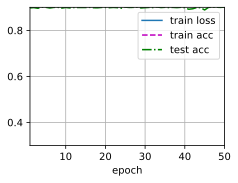

In [74]:
num_epochs = 50
train(MLP, dataloader, dataloader_test, loss, num_epochs, trainer)    

# 第三组的基于PCA+KNN

In [1]:
%matplotlib inline
import collections
import math
import os
os.makedirs("/kaggle/working/data")
os.chdir("/kaggle/input/d2lcode")
import shutil
import pandas as pd
import torch
import torchvision
from torch.utils import data
from IPython import display
from torchvision import transforms
from torch import nn
import d2l
d2l.use_svg_display()

In [2]:
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    # 自定义展平操作的Lambda函数
    flatten_transform = transforms.Lambda(lambda img: img.view(-1))   #其实就是把tensor后的(c,h,w)的数据形状展平为一维tensor

# 创建包含ToTensor和展平操作的变换对象
    trans = transforms.Compose([transforms.ToTensor(), flatten_transform])
    mnist_train = torchvision.datasets.FashionMNIST(
        root="/kaggle/working/data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="/kaggle/working/data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=4),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=4))

batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

100%|██████████| 26421880/26421880 [00:03<00:00, 7217398.29it/s] 


Extracting /kaggle/working/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 112050.23it/s]


Extracting /kaggle/working/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 2089114.86it/s]


Extracting /kaggle/working/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10512306.23it/s]

Extracting /kaggle/working/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/data/FashionMNIST/raw



In [6]:
alldate=[]
ALLlable=[]
for x,y in train_iter:
    alldate.append(x)
    ALLlable.append(y)
ALL_dataTensor = torch.cat(alldate, dim=0)
ALL_Label = torch.cat(ALLlable, dim=0)
allTestdate=[]
ALLTestlable=[]
for x,y in test_iter:
    allTestdate.append(x)
    ALLTestlable.append(y)
ALL_TestdataTensor = torch.cat(allTestdate, dim=0)
ALL_TestLabel = torch.cat(ALLTestlable, dim=0)
    




In [4]:
from sklearn.decomposition import PCA
import numpy as np
from sklearn.preprocessing import StandardScaler
 

 
# feature normalization (feature scaling)
X_scaler = StandardScaler()
x = X_scaler.fit_transform(ALL_dataTensor)
y_scaler = StandardScaler()
y = y_scaler.fit_transform(ALL_TestdataTensor)
 
# PCA
pca = PCA(n_components=0.95)# 保证降维后的数据保持90%的信息
pca.fit(x)
ALL_dataTensor=torch.tensor(pca.transform(x))
ALL_TestdataTensor=torch.tensor(pca.transform(y))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import torch
from torch.nn import functional as F

class KNNClassifier:
    def __init__(self, k):
        self.k = k

    def fit(self, X_train, y_train):
        # 将数据移动到 GPU 上
        self.X_train = X_train.cuda()
        self.y_train = y_train.cuda()

    def predict(self, X_test):
        # 将测试数据移动到 GPU 上
        X_test = X_test.cuda()

        predictions = []
        for x in X_test:
            distances = torch.norm(self.X_train - x, dim=1)  # 计算欧氏距离
            _, indices = torch.topk(distances, self.k, largest=False)  # 找到最近的k个邻居的索引
            knn_labels = self.y_train[indices]
            predicted_label = torch.mode(knn_labels)  # 选择最频繁的类别作为预测结果
            predictions.append(predicted_label[0])
        return torch.tensor(predictions).cpu()  # 将结果移回 CPU

# 生成一些示例数据
# ...



In [4]:
from sklearn.decomposition import PCA
import numpy as np
from sklearn.preprocessing import StandardScaler
Result=[]
for time in range(7):
    alldate=[]
    ALLlable=[]
    for x,y in train_iter:
        alldate.append(x)
        ALLlable.append(y)
    ALL_dataTensor = torch.cat(alldate, dim=0)
    ALL_Label = torch.cat(ALLlable, dim=0)
    allTestdate=[]
    ALLTestlable=[]
    for x,y in test_iter:
        allTestdate.append(x)
        ALLTestlable.append(y)
    ALL_TestdataTensor = torch.cat(allTestdate, dim=0)
    ALL_TestLabel = torch.cat(ALLTestlable, dim=0)
    X_scaler = StandardScaler()
    x = X_scaler.fit_transform(ALL_dataTensor)
    y_scaler = StandardScaler()
    y = y_scaler.fit_transform(ALL_TestdataTensor)
    ratio=0.7+0.05*time
    pca = PCA(n_components=ratio)# 保证降维后的数据保持90%的信息
    pca.fit(x)
    ALL_dataTensor=torch.tensor(pca.transform(x))
    ALL_TestdataTensor=torch.tensor(pca.transform(y))
    AccuracyArray=[]
    for i in range(1,21):
        knn_classifier = KNNClassifier(k=i)
        knn_classifier.fit(ALL_dataTensor, ALL_Label)
# 进行预测
        predictions = knn_classifier.predict(ALL_TestdataTensor)
        num_equal = torch.sum(predictions == ALL_TestLabel).item()
        AccuracyArray.append(num_equal/ALL_TestLabel.shape[0])
    Result.append(AccuracyArray)
    print("在PCA保留{}信息的情况下，在K为{}时取得最大精度为{}".format(ratio,AccuracyArray.index(max(AccuracyArray)),max(AccuracyArray)))
        
    


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


在PCA保留0.7信息的情况下，在K为7时取得最大精度为0.8408
在PCA保留0.75信息的情况下，在K为7时取得最大精度为0.8461
在PCA保留0.7999999999999999信息的情况下，在K为10时取得最大精度为0.8534
在PCA保留0.85信息的情况下，在K为3时取得最大精度为0.8575
在PCA保留0.8999999999999999信息的情况下，在K为6时取得最大精度为0.8617
在PCA保留0.95信息的情况下，在K为7时取得最大精度为0.861


InvalidParameterError: The 'n_components' parameter of PCA must be an int in the range [0, inf), a float in the range (0, 1), a str among {'mle'} or None. Got 1.0 instead.

In [ ]:
nouseResult=[]
for i in range(1,21):
    knn_classifier = KNNClassifier(k=i)
    knn_classifier.fit(ALL_dataTensor, ALL_Label)

# 进行预测
    predictions = knn_classifier.predict(ALL_TestdataTensor)
    num_equal = torch.sum(predizaictions == ALL_TestLabel).item()
    nouseResult.append(num_equal/ALL_TestLabel.shape[0])
    print("K值为{}时的精确度为{}".format(i,num_equal/ALL_TestLabel.shape[0]))

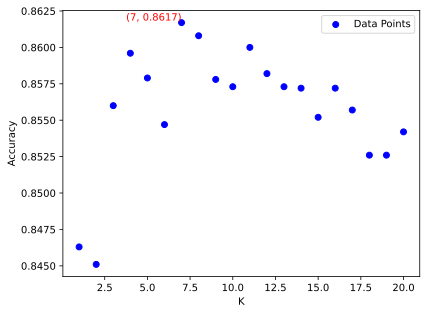

In [10]:
import matplotlib.pyplot as plt

# 假设你有一个包含 x 和 y 值的列表
x_values = [i for i in range(1,21)]
y_values = Result[4]

# 找到最高值的索引和值
max_index = y_values.index(max(y_values))
max_value = y_values[max_index]
max_x = x_values[max_index]

# 绘制散点图
plt.scatter(x_values, y_values, label='Data Points', color='blue', marker='o')

# 添加标题和标签

plt.xlabel('K')
plt.ylabel('Accuracy')

# 在最高点旁边添加 x 和 y 的值
plt.text(max_x, max_value, f'({max_x}, {max_value:.4f})', color='red', ha='right', va='bottom')

# 显示图例
plt.legend()

# 显示散点图
plt.show()


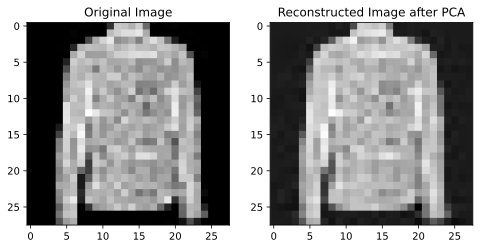

In [35]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 假设你有一个形状为 (60000, 28, 28) 的图像张量
# 这里可以根据实际情况调整张量的内容

# 生成模拟数据
num_samples = 60000
image_size = 28
images = ALL_dataTensor.reshape(60000,28,28)

# 将图像张量展平为向量，形状变为 (60000, 784)
flattened_images = images.reshape(num_samples, -1)

# 设置 PCA 维度
n_components = 500  # 你可以根据需要选择降维后的维度

# 初始化 PCA 模型
pca = PCA(n_components=n_components)

# 降维
reduced_images = pca.fit_transform(flattened_images)

# 如果需要，可以通过 inverse_transform 将降维后的数据映射回原始空间
reconstructed_images = pca.inverse_transform(reduced_images)

# 显示原始图像和降维后的图像进行对比
plt.figure(figsize=(8, 4))

# 随机选择一个样本进行对比
sample_index = np.random.randint(0, num_samples)

plt.subplot(1, 2, 1)
plt.imshow(images[sample_index].squeeze(), cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_images[sample_index].reshape(image_size, image_size), cmap='gray')
plt.title('Reconstructed Image after PCA')

plt.show()
